# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**  - Essam Abas
***
### Tasks:

In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  
***

## Pipeline Description

In this project, I built a computer vision pipeline to detect lane lines and creat extrapolated boundary lines. The pipeline is as follows:

- Convert frame to grayscale
- Create masks for yellow/white pixels
- Apply a Gaussian smoothing filter
- Apply a Canny edge detection
- Create an additional mask to focus on the "region of interest" in front of the vehicle
- Convert the points(i.e. pixels) in XY space to lines in Hough space
- Sort Left and Right Lane lines based on the calculated slope
- Apply Curve-Fitting to each Lane-Points to draw solid lines
- Vanishing-point was substitued by the deepst point detected [y_min]
- Using the extrema of the lines generated, create two averaged lane lines
- TODO: stabilize lane-lines - the potential works are to use HistoryBuffer and use Mean or weighted factors, or use tracking filters such as: kalman filter to predict/stabilize lane-lines. I think this out of scope of this simple-project.
- Draw the lane-lines for each frame

The pipeline described above has been tested on all test_images and a copy of processed-images has been created into the `test_images_output` directory, computer vision stages can be seen: and you can use the images in your writeup report.

**Canny-Thresholds:**
- $$Kernel Size = 5$$
- $$Low Threshold=50$$
- $$High Threshold=150$$
    
**Hough-Line Parameters:**
- $$rho=2$$
- $$theta=pi/180$$
- $$Threshold = 15$$
- $$Minimum Line Length = 40$$
- $$Maximum Line Gap = 20$$

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Import Packages

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Helper Functions

This section includes all Helper functions used within processing-images.

Below are some helper functions that are used in images processing. The description are provided in the code comments

In [11]:
import math
import statistics

next_frame, current_frame =[],[]      
        
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_slope(x1,y1,x2,y2):
    """
    Get Lines slope based on two points - the function avoids dividing by zero. 
    """     
    if (x2-x1) == 0:
        return 0
    return ((y2-y1)/(x2-x1))
    

def get_vanishing_point(left_coeffs, right_coeffs):
    """
    TODO: The function should get the interesting point between two-lines 
    """    
    equation = left_coeffs - right_coeffs
    x = -equation[1] / equation[0]
    y = np.poly1d(left_coeffs)(x)
    x, y = map(int, [x, y])
    return [x, y]
    
def extrapolate_lines(x_lst, y_lst, x_min, x_max):
    """
    Numpy Polyfit is used as a linear-regression to fit and extrapolate lane-lines.
    x_lst/y_lst: are array of lane-points
    x_min/ x_may: represent the minimum/maximum points - to draw solid lane-lines
    Returns: extrapolated 2 lane-points
    """
    # check that x_lst/y_lst are not empty
    if((len([x_lst]) == 0) or (len(y_lst) == 0)):
        #print ('no lane detected')
        return 1 
    
    # extract most-depth point detect
    # TODO: use estimate vanishing-point by using both lane-lines coeffecients and solve for the interesction
    z = np.polyfit(x_lst, y_lst, 1)
    f = np.poly1d(z)
    
    x1 = x_max
    y1 = f(x1).astype(int)
    x2 = x_min
    y2 = f(x2).astype(int)
    
    #swap x,y coordinates to fit on image - x(width), y(height)
    return y1,x1,y2,x2
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # get image-size
    imshape=img.shape
    
    # initialize y_min with the image-height
    y_min = imshape[1]
    y_max = imshape[1]
    
    # list for lane-points, slope
    left_lane_slope_lst = []
    right_lane_slope_lst = []
    left_lane_point_x_lst = []
    left_lane_point_y_lst = []
    right_lane_point_x_lst = []
    right_lane_point_y_lst = []
    l_lane,r_lane,l_slope, r_slope = [],[],[],[]
    
    # check if any lines are detected.
    if lines is None:
        return img
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # get line-slope
            slope = get_slope(x1,y1,x2,y2)
            if  slope < -0.4 and slope > -0.9:
                # left-lane should have negative-slope
                left_lane_slope_lst.append(slope)
                left_lane_point_x_lst.append(x1)
                left_lane_point_x_lst.append(x2)
                left_lane_point_y_lst.append(y1)
                left_lane_point_y_lst.append(y2)
                l_slope.append(slope)
                l_lane.append(line)                
            elif slope > 0.4 and slope < 0.9:
                # right-lane should have positive-slope
                right_lane_slope_lst.append(slope)
                right_lane_point_x_lst.append(x1)
                right_lane_point_x_lst.append(x2)
                right_lane_point_y_lst.append(y1)
                right_lane_point_y_lst.append(y2)
                r_slope.append(slope)
                r_lane.append(line)                
            # determine vanishing point 
            y_min = min(y_min,y1,y2)
            # draw-lines    
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    try:    
        # fit-left lane        
        x1,y1,x2,y2 = extrapolate_lines(left_lane_point_y_lst,
                                        left_lane_point_x_lst, 
                                        y_min, 
                                        y_max)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness+2)
        # fit-right lane
        x3,y3,x4,y4 = extrapolate_lines(right_lane_point_y_lst,
                                        right_lane_point_x_lst,
                                        y_min, 
                                        y_max)
        cv2.line(img, (x3, y3), (x4, y4), [0,255,0], thickness+2)
    except:
        #print("Unknown Error has been occured while fitting lane-lines")
        return 1
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def add_subplot(fig, img, col_idx, title):
    # suplot-parameters index nrow, ncolumns, index
    a = fig.add_subplot(1, 5, col_idx)
    imgplot = plt.imshow(img)
    # set Ttile of subplot
    a.set_title(title)

## Processing-Pipeline

The function `process_image` includes the whole pipeline described above.  

In [24]:
def process_image(image, optional_show_fig = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)    
    
    if optional_show_fig == True: 
        # define new figure
        fig = plt.figure()
        # suplot-parameters index nrow, ncolumns, index
        figure_col_index = 1
        add_subplot(fig, frame, figure_col_index, 'Oringal')
    
    # extract gray-image
    gray_image = grayscale(image)
    # Apply White-color-mask
    mask_white = cv2.inRange(gray_image, 200, 255)
    res_image = cv2.bitwise_and(gray_image, mask_white)
    
    if optional_show_fig == True: 
        figure_col_index += 1
        add_subplot(fig, res_image, figure_col_index, 'Masked')
    
    # Apply Gaussian-blur
    kernel_size = 5
    gauss_gray = gaussian_blur(res_image,kernel_size)
    #Apply Canny-Edge Detection
    res_image = canny(gauss_gray,low_threshold=50 ,high_threshold=150)
    
    if optional_show_fig == True:     
        figure_col_index += 1
        add_subplot(fig, res_image, figure_col_index, 'Canny')
    
    # Define a region-of-Interest
    imshape = frame.shape
    vertices = np.array([[(0,imshape[0]),
                          ((imshape[1]/2)-10, (imshape[0]/2)+20), 
                          ((imshape[1]/2)+10, (imshape[0]/2)+20), 
                          (imshape[1],imshape[0])]], dtype=np.int32)
    res_image = region_of_interest(res_image, vertices)
    
    # Run Hough on edge detected image
    res_image = hough_lines(res_image, rho=2, theta = np.pi/180, 
                            threshold=15, min_line_len = 40, 
                            max_line_gap = 20)
    if optional_show_fig == True:     
        figure_col_index += 1
        add_subplot(fig, res_image, figure_col_index, 'Hough')

    # Iterate over the output "lines" and draw lines on a blank image
    result = weighted_img(res_image, image, α=0.8, β=1., γ=0.)
    if optional_show_fig == True:
        figure_col_index += 1
        add_subplot(fig, result, figure_col_index, 'Processed')
    return result

## Test Images

Build your pipeline to work on the images in the directory "test_images"  

The pipeline described above has been tested on all test_images and a copy of processed-images has been created into the `test_images_output` directory, computer vision stages can be seen: and you can use the images in your writeup report.
**You should make sure your pipeline works well on these images before you try the videos.**

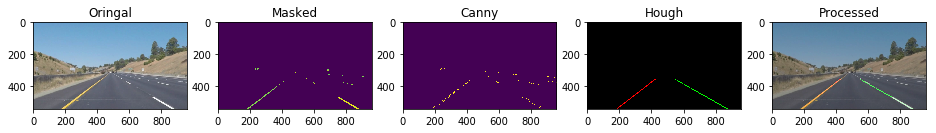

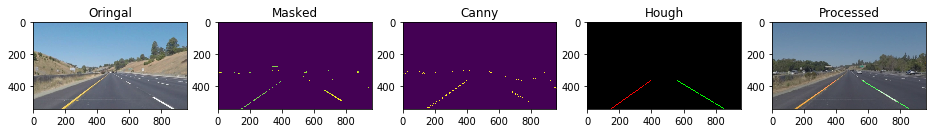

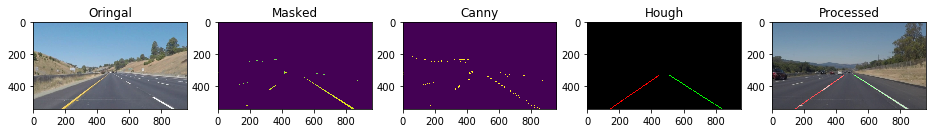

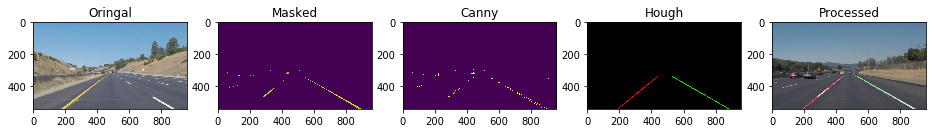

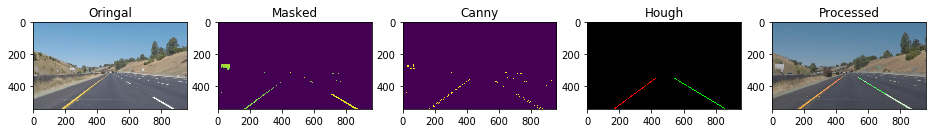

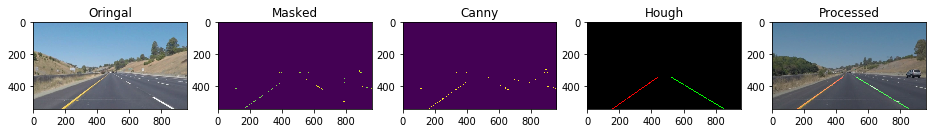

In [25]:
import os
plt.rcParams["figure.figsize"] = [16,9]
# Loop to all Images in Test-Images Folder
for source_img in os.listdir("test_images/"):
    # extract frame-image
    img = mpimg.imread('test_images/'+ source_img)
    
    result = process_image(img,
                           optional_show_fig=True)
    
    # Iterate over the output "lines" and draw lines on a blank image
    # save processed images to the test_images_output directory.
    mpimg.imsave("test_images_output/annotated_"+source_img,result)   



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [32]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 14.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.49 s, sys: 246 ms, total: 2.73 s
Wall time: 15 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [28]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 15.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.95 s, sys: 689 ms, total: 8.64 s
Wall time: 47.5 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflection

### Justification:
- The current pipeline worked well on gray-scale images; thus i avoided using HSV/HSL images to extract the yellow lanes - i found it very error-prone based on the selected ranges.
- The current pipeline kept the algorithms simple and straightforward to meet the Project submission dead-line
- Working on Video showed that lane-lines could not be found on many frames and real-world scenerios will be more challenging

### Shortcomings would be:
- Using Line-Regression would not fit for curves
- Shadows on the Road/Lighthing-conditions, or damaged/missing lane-lines affected the processing of lane-lines 
- Vanishing-Point calculation should be mathmatically be done
- Stabilizing Lane-Lines would help maintaing the lane-lines, if the Images could not contain any lines


### Suggest possible improvements to your pipeline

Possible improvements would be:
- Use higher-degree of Polynomial fitting to match lines on curves
- Use Line-Interesection Algorithms to better calculate the Vanishing-Point
- Use Tracking - or Buffer to stabilize Lane-Line recognition

More description are also provided in the writeup `writeup.md` saved in the workspace



## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [30]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:31<00:00,  8.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.16 s, sys: 575 ms, total: 4.73 s
Wall time: 34.5 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))